In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_from_order_func
from optimizers.utils._utils import get_csv_data
from optimizers.utils.cross_validators import vbt_cv_sliding_constructor
from optimizers.pipes.pipe import SQLPipe

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'kucoin'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS)

In [3]:
assets = ['BNB-USDT', 'API3-USDT']
slicer = 1000 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=3)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=3)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13991
Test data length: 4198
Train fold length 3264


In [9]:
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70  2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# BATANKR 303 0.7 -2.7 0.4 3.e-9 1.7e-5 LOG
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN)
# BNBTRX (LOG) failed
# BNBTRX CUMMLOG 615 1.9 -2.2 1.4 8e-6 0.3 <- low sharpe, but high WR. High duration. Deploy with minor alloc?

PERIOD = 70
UPPER = 4.3
LOWER = -4.1
EXIT = 1.2
DELTA = 7.e-9
VT = 3e-5
BURNIN = 500
MODEL = 'log'
HEDGE = 'beta'
SLIPPAGE = 0.0020
FREQ = "h"

In [10]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    mode=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

-0.0014000551024777588


<AxesSubplot:xlabel='time'>

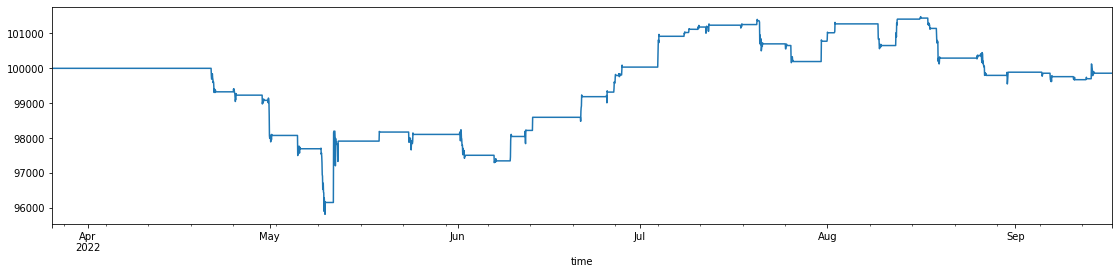

In [11]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [12]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].median() / np.abs(res.PnL[res.PnL < 0].median()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {pf.sharpe_ratio():.4f}")

Total trades: 53
Executed trades: 106
Profit Ratio: 0.506
Net long-short win rate: 58.49%
Median trade profit: 56.25
Mean trade profit: -2.64
STD of trade profit: 530.53
Sharpe ratio: -0.0260


<AxesSubplot:xlabel='Entry Timestamp'>

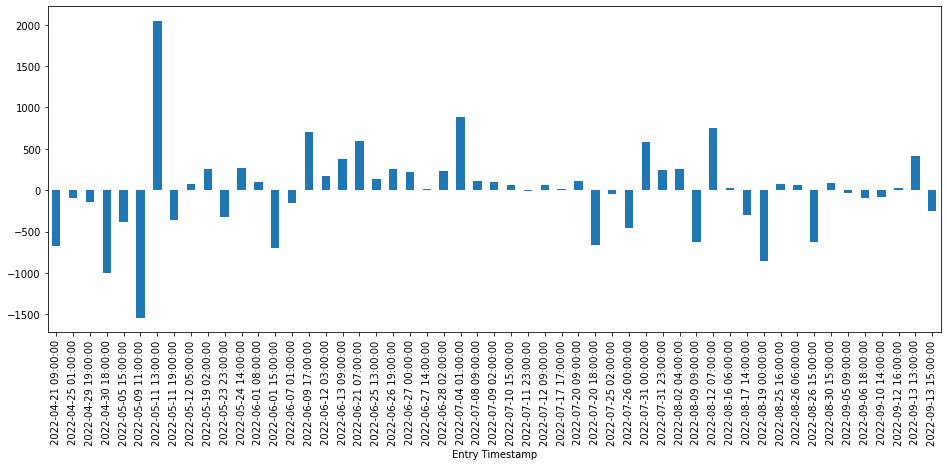

In [13]:
res.PnL.plot(kind="bar", figsize=(16,6))